In [1]:
import functools
import itertools
import logging
import math
import os
import pickle
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import yaml

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 12.0)})
sns.set_style("whitegrid")

import numpy as np
import pandas as pd
import torch.nn.functional as F

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
from lda4rec.datasets import Interactions, DataLoader, random_train_test_split
from lda4rec.evaluations import mrr_score, precision_recall_score, auc_score, summary
from lda4rec.estimators import MFEst, PopEst, LDA4RecEst, SNMFEst
from lda4rec.utils import process_ids, cmp_ranks

In [3]:
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.distributions import constraints
from pyro.infer import SVI, Predictive, Trace_ELBO, TraceEnum_ELBO, config_enumerate

In [4]:
import neptune
# init dummy neptune to avoid problems with logging
neptune.init('a/b', backend=neptune.OfflineBackend()) 

In [5]:
from icecream import ic, install

install()
# configure icecream
def ic_str(obj):
    if hasattr(obj, "shape"):
        return f"{obj} "  #
    else:
        return str(obj)

In [6]:
ic.configureOutput(argToStringFunction=ic_str)

## Experimenting with different estimators

In [7]:
loader = DataLoader()
data = loader.load_movielens("100k")

In [8]:
max_interactions = 200
data.max_user_interactions_(max_interactions)

In [9]:
data.implicit_(0.)
train, test = random_train_test_split(data)

In [10]:
pop_est = PopEst()
pop_est.fit(train)

In [11]:
summary(pop_est, train=train, test=test)

,train,test
metric,,
prec,0.290656,0.102142
recall,0.053486,0.072826
mrr,0.026206,0.035311
auc,0.910181,0.878300


In [26]:
mf_est = MFEst(embedding_dim=4, n_iter=10)
mf_est.fit(train)

INFO:lda4rec.estimators:Epoch     0: loss 0.4082411970641162
INFO:lda4rec.estimators:Epoch     1: loss 0.2269917070462897
INFO:lda4rec.estimators:Epoch     2: loss 0.1436683242788186
INFO:lda4rec.estimators:Epoch     3: loss 0.11611383964081068
INFO:lda4rec.estimators:Epoch     4: loss 0.10381007379776723
INFO:lda4rec.estimators:Epoch     5: loss 0.09459885932706498
INFO:lda4rec.estimators:Epoch     6: loss 0.0877933754459829
INFO:lda4rec.estimators:Epoch     7: loss 0.08399088827742113
INFO:lda4rec.estimators:Epoch     8: loss 0.08052082148858825
INFO:lda4rec.estimators:Epoch     9: loss 0.07856620458533635


0.07856620458533635

In [29]:
summary(mf_est, train=train, test=test)

AttributeError: 'NoneType' object has no attribute 'is_cuda'

In [16]:
lda_est = LDA4RecEst(embedding_dim=4, n_iter=10_000, batch_size=128, learning_rate=0.001, use_jit=True)

In [17]:
lda_est.fit(train)

INFO:lda4rec.estimators:Epoch     0: loss 547173.75
INFO:lda4rec.estimators:Epoch   100: loss 553235.375
INFO:lda4rec.estimators:Epoch   200: loss 485098.0
INFO:lda4rec.estimators:Epoch   300: loss 480560.84375
INFO:lda4rec.estimators:Epoch   400: loss 476614.34375
INFO:lda4rec.estimators:Epoch   500: loss 445108.125
INFO:lda4rec.estimators:Epoch   600: loss 453517.71875
INFO:lda4rec.estimators:Epoch   700: loss 406715.8125
INFO:lda4rec.estimators:Epoch   800: loss 422745.25
INFO:lda4rec.estimators:Epoch   900: loss 433715.4375
INFO:lda4rec.estimators:Epoch  1000: loss 484386.59375
INFO:lda4rec.estimators:Epoch  1100: loss 425419.9375
INFO:lda4rec.estimators:Epoch  1200: loss 407682.25
INFO:lda4rec.estimators:Epoch  1300: loss 397133.0625
INFO:lda4rec.estimators:Epoch  1400: loss 408177.53125
INFO:lda4rec.estimators:Epoch  1500: loss 429413.78125
INFO:lda4rec.estimators:Epoch  1600: loss 418844.59375
INFO:lda4rec.estimators:Epoch  1700: loss 416760.625
INFO:lda4rec.estimators:Epoch  18

363266.75

In [ ]:
summary(lda_est, train=train, test=test)

[autoreload of lda4rec.estimators failed: Traceback (most recent call last):
  File "/Users/fwilhelm/.miniconda3/envs/lda4rec/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/fwilhelm/.miniconda3/envs/lda4rec/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/fwilhelm/.miniconda3/envs/lda4rec/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/fwilhelm/.miniconda3/envs/lda4rec/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/fwilhelm/.miniconda3/envs/lda4rec/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/fwilhelm/.miniconda3/envs/lda4rec/lib/python3.8/site-pac

(0.0, 5.0)

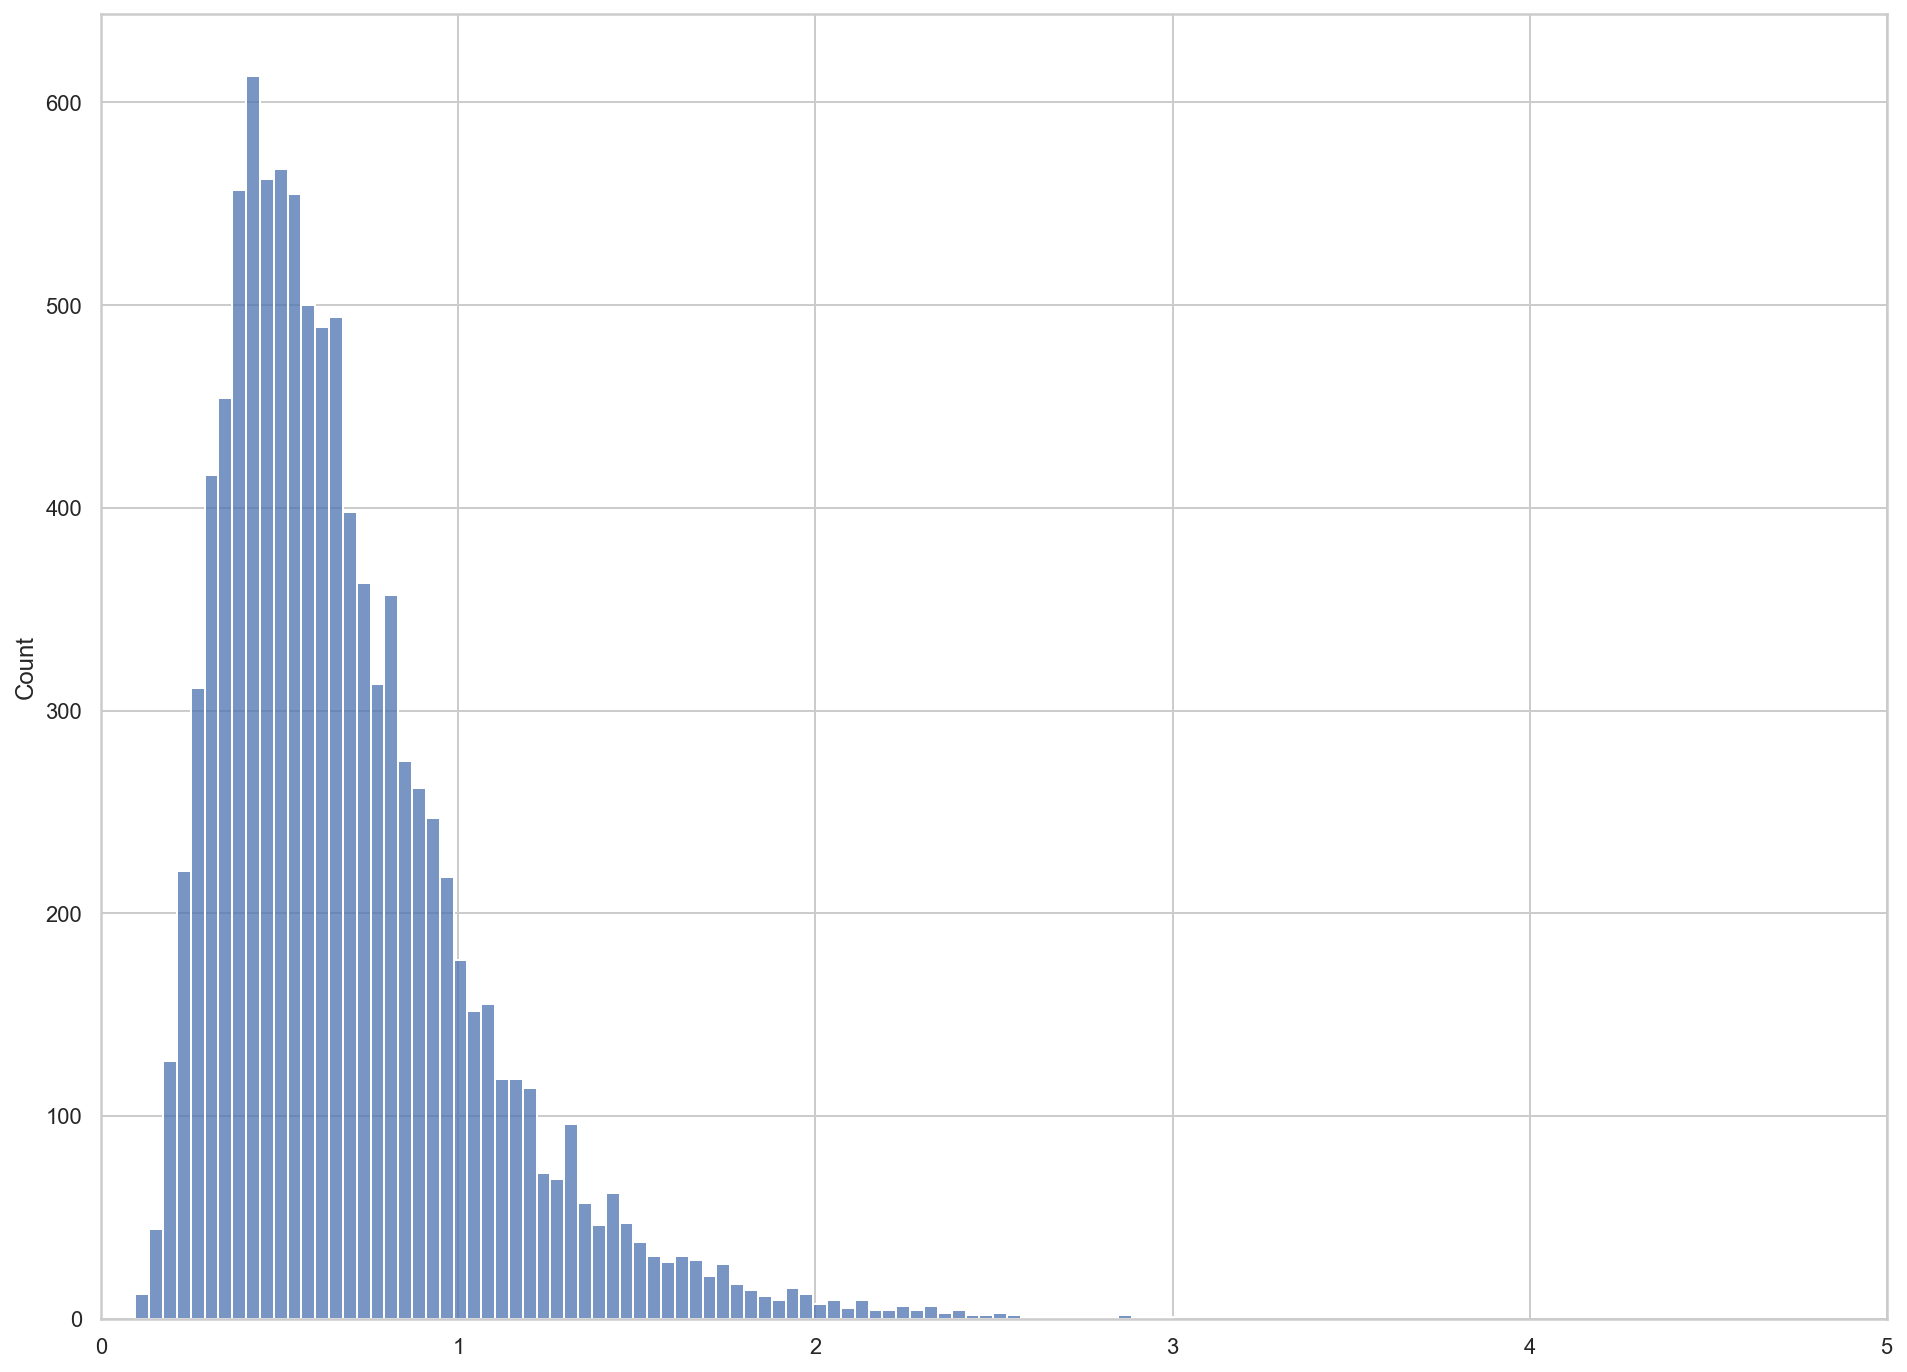

In [84]:
sns.histplot(dist.LogNormal(-0.5,0.5).sample((10_000,)))
plt.xlim(0, 5)

In [55]:
np.exp(-0.5)

0.6065306597126334

In [24]:
torch.rand(torch.bincount(torch.arange(10)).shape)

tensor([0.1223, 0.3370, 0.8262, 0.8811, 0.8574, 0.0309, 0.0379, 0.9681, 0.5868,
        0.8301])

In [42]:
lda_est.user_pop_devs.shape

NameError: name 'lda_est' is not defined

In [52]:
lda_est.user_pop_devs.shape

torch.Size([610])

## Matrix Factorization as aLDA formulation

In [706]:
user_id = 128
orig_scores = mf_est.predict(np.array([user_id], dtype=np.int))
item_probs = mf_est.get_item_probs(user_id)

In [707]:
cmp_ranks(orig_scores, item_probs, eps=1e-5)

True

In [708]:
torch.where

<function _VariableFunctionsClass.where>

In [709]:
np.sum(np.argsort(orig_scores) != np.argsort(item_probs))

8

In [710]:
torch.min(torch.eye(10), dim=0)

torch.return_types.min(
values=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
indices=tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [711]:
torch.zeros(1).shape

torch.Size([1])

In [712]:
torch.min(torch.arange(10)-1.).shape

torch.Size([])

In [713]:
torch.zeros(0)

tensor([])

In [60]:
n_samples = 200
rng = np.random.default_rng(42)
model_params["interactions"] = data.interactions

predictive = Predictive(model, guide=guide, num_samples=n_samples)
samples = {
    k: v.detach().cpu().numpy()
    for k, v in predictive(**model_params).items()
}

IndexError: index 1 is out of bounds for dimension 0 with size 1